In [1]:
from dataset import Dataset

dataset = Dataset('Caltech101')

In [2]:
classes = ["emu","elephant","crocodile"]

dataset.restrictDataset(classes)
dataset.getLength()

167

In [3]:
training_set,test_set = dataset.splitTrainingTest(0.7)
print (training_set.getLength())
print (test_set.getLength())

116
51


# 3.1

In [4]:
#Perché abbiamo suddiviso il dataset in due parti (training e test set)? Tale suddivisione può essere evitata? Perché?
#
#Lo abbiamo fatto per creare un modello di BOW a partire dal training_set e verificarne il corretto 
#funzionamento con un test_set che non contegna gia gli stessi elementi

In [5]:
from skimage import io as sio
from skimage.feature import daisy

#la funzione "daisy" si aspetta che l'immagine analizzata sia in scala di grigi
#dunque passiamo l'argomento "as_grey=True" in fase di lettura dell'immagine
im = sio.imread(dataset.getImagePath('elephant',0),as_grey=True)
daisy_features = daisy(im)

In [6]:
daisy_features.shape

(49, 68, 200)

In [7]:
#Utilizziamo la funzione reshape di numpy
#passiamo come parametro una tupla contenente le nuove dimensioni
#del tensore dopo il reshape. Quando impostiamo una delle dimensioni a "-1"
#il suo valore effettivo viene ricalcolato a partire dalle altre dimensioni
#specificate e dalle dimensioni del tensore di partenza
daisy_features = daisy_features.reshape(-1,200)
daisy_features.shape

(3332, 200)

In [8]:
len(daisy_features)

3332

# 4.1

In [9]:
#La funzione daisy permette di specificare diversi parametri (vedi documentazione). 
#Tra essi, uno è legato direttamente al numero di feature che verranno estratte dall'immagine. Quale?
#
# step(Distance between descriptor sampling points) diminuendo questo parametro andiamo a prende un maggior numero di
# campioni nella nostra immagine e prendiamo un numero di feature maggiore
print((daisy(img=im,step=2)).shape)
print((daisy(img=im,step=1)).shape)

(98, 135, 200)
(195, 270, 200)


In [10]:
daisy_features_step4 = daisy(img=im,step=4).reshape(-1,200)
daisy_features_step10 = daisy(img=im,step=10).reshape(-1,200)

print("Step4: {:<6}\nStep10: {:<4}\n".format(len(daisy_features_step4),len(daisy_features_step10)))

Step4: 3332  
Step10: 540 



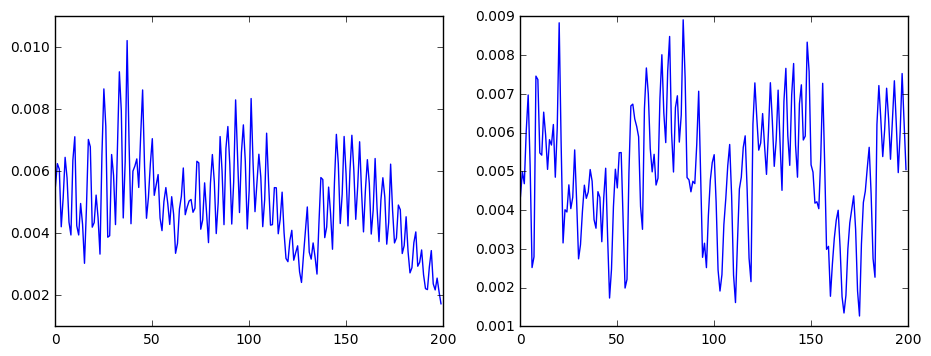

In [11]:
from matplotlib import pyplot as plt
import numpy as np
#generiamo due interi casuali per selezionare due righe di daisy_features
#la funzione randint genera un intero casuale compreso tra zero e
#len(daisy_features) (numero di righe di daisy_features) escluso
random_index1 = np.random.randint(0,len(daisy_features_step10))
random_index2 = np.random.randint(0,len(daisy_features_step10))

#selezioniamo le due righe corrispondenti alle feature scelte in maniera casuale
feature1 = daisy_features_step10[random_index1,:]
feature2 = daisy_features_step10[random_index2,:]

#crea una nuova figura 11 x 4 pollici
plt.figure(figsize=(11,4))

#Inseriamo plot multipli. Per la precisione costruiamo una griglia di una riga e due colonne
plt.subplot(1,2,1)
#e impostiamo la prima posizione della griglia come plot corrente
#grafichiamo in primo vettore di feature selezionato
plt.plot(feature1)

plt.subplot(1,2,2)
plt.plot(feature2)

plt.show()

# 4.2

In [12]:
#Perché l'asse delle ascisse va da 0 a 200?
#Le due feature visualizzate sono state estratte dalla stessa immagine, tuttavia sono diverse. Perché?
#Cambierebbe qualcosa se invece di scegliere due descrittori a caso, ne scegliessimo due adiacenti? Perché?
#
#perchè 200 è il numero delle dimensioni delle colonne, ovvero il numero di caratteristiche per feature
#perchè sono feature estratte da due punti diversi dell'immagine e quindi possono essere incorrellate
#Due descrittori molto vicini presentano molto più probabilmente delle caratteristiche simili o quasi identiche

In [13]:
im2 = sio.imread(dataset.getImagePath('emu',-1),as_grey=True)
daisy_features2_step10 = daisy(img=im,step=10).reshape(-1,200)
len(daisy_features2_step10)

540

In [14]:
#da notare che "vstack" prende in input una tupla contenente
#le matrici da concatenare e non due parametri distinti
#alla tupla può essere sostituita una qualsiasi struttura dati 
#di tipo "iterable", come ad esempio una lista
concatenated_features = np.vstack((daisy_features_step10,daisy_features2_step10))
print(len(daisy_features_step10))
print(len(daisy_features2_step10))
print(len(concatenated_features))

540
540
1080


# 4.2

In [15]:
def extract_features(data_set):
    tmp_list = list()
    img_processed = 0
    img_tot = data_set.getLength()
    print("Inizio il processing...")
    for class_name in data_set.getClasses():
        for i in range(0,data_set.getClassLength(class_name)):
            im = sio.imread(data_set.getImagePath(class_name,i),as_grey=True)
            daisy_features = daisy(img=im,step=10).reshape(-1,200)
            tmp_list.append(daisy_features)
        img_processed+=data_set.getClassLength(class_name)
        print("Processate: {:<5} su {:<7}".format(img_processed,img_tot))
    return np.vstack(tmp_list)

In [16]:
training_local_features = extract_features(training_set)

Inizio il processing...
Processate: 35    su 116    
Processate: 79    su 116    
Processate: 116   su 116    


In [17]:
training_local_features.shape

(61236, 200)

In [18]:
from time import time
from sklearn.cluster import MiniBatchKMeans as KMeans
import warnings

warnings.filterwarnings("ignore")

#inizializziamo l'oggetto "KMeans" impostando il numero di centroidi
kmeans = KMeans(500)
#avviamo il kmeans sulle feature estratte
start_time=time()
kmeans.fit(training_local_features)
end_time=time()
elapsed_time=end_time-start_time
print ("Total time: {0:0.2f} sec".format(elapsed_time))

Total time: 3.41 sec


In [19]:
kmeans.cluster_centers_.shape

(500, 200)

# 4.3

In [20]:
#Che ruolo ha il clustering nella costruzione di un modello di tipo BOVW? Se ne potrebbe fare a meno? Perché?
#
#Il clustering serve a raggruppare un insieme di features simili e nel BOVW è essenziale in quanto ci consente di 
#stabilire quali siano le caratteristiche di una determinata Word

# 4.4

In [21]:
#Che effetto avrebbe cambiare la dimensione del vocabolario? 
#Quale metodo dovrebbe essere "più preciso"? quale "più lento"?
#
#Cambiando la dimensione troveremmo un maggior numero di parole e quindi potremmo avere una maggior precisione 
#nella caratterizzazione visuale delle singole parole, ma cio comporta un costo computazionale maggiore

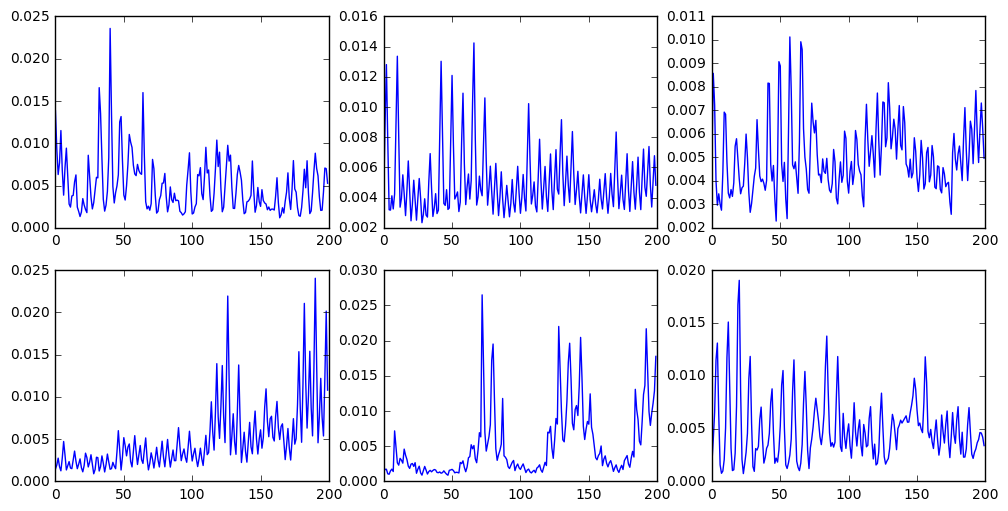

In [22]:
centers = np.random.permutation(kmeans.cluster_centers_)

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(centers[i])

plt.show()

# 4.5

In [23]:
#Le parole visuali graficate sono tutte abbastanza diverse tra loro. Perché? 
#Cosa succede se grafichiamo le prime 6 parole visuali nell'ordine in cui ci sono state fornite dal K-Means? 
#Cambia qualcosa? Perché?
#
#Le parole visuali sono diverse poiche sono prese in maniera random dalle 500 ipotizzate inizialmente 
#Le prime sei parole saranno prese da centri vicini e quindi potrebbero avere degli andamenti più simili e correlati

In [24]:
assignments=kmeans.predict(daisy_features)

#la funzione histogram prende in input il vettore degli assegnamenti
#il numero di bin dell'istogramma (= numero di parole visuali)
#il range degli indici in assignments (da 0 a 499)
#histogram restituisce l'istogramma e il vettore dei centri, che scartiamo
#inserendo il trattino "_"
bovw_representation, _ = np.histogram(assignments, bins=500, range=(0,499))

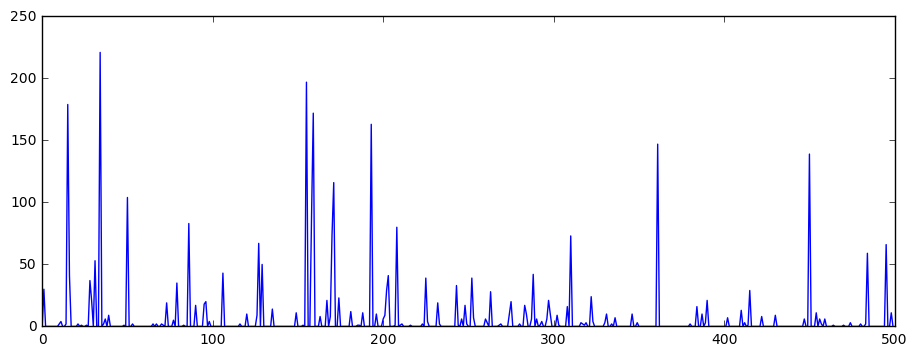

In [25]:
plt.figure(figsize=(11,4))

plt.plot(bovw_representation)
plt.show()

# 5.1

In [26]:
#Che dimensioni ha la rappresentazione ottenuta? Perché? Quali sono i valori minimo e massimo in essa contentuti?
#
#La rappresentazione ottenuta ha lungo l'asse x come valore 500 che è il numero di parole nel nostro dizionario
#Il minimo e il massimo di y invece rappresentano il numero di occorrenze di una determinata
#parola nell'immagine analizzate

# 5.2

In [27]:
from skimage.color import rgb2grey

def extract_and_describe(image,kmeans_dict):
    #converts from rgb to grayscale
    img_grey = rgb2grey(image)
    # extract the features
    daisy_features = daisy(img_grey,step=10).reshape(-1,200)
    # predicts the nearest kmeans centres for each feature
    assignments = kmeans_dict.predict(daisy_features)
    # generate a series of histogram for each centroid
    bovw_graph, _ =np.histogram(assignments,bins=500,range=(0,499)) 
    return bovw_graph

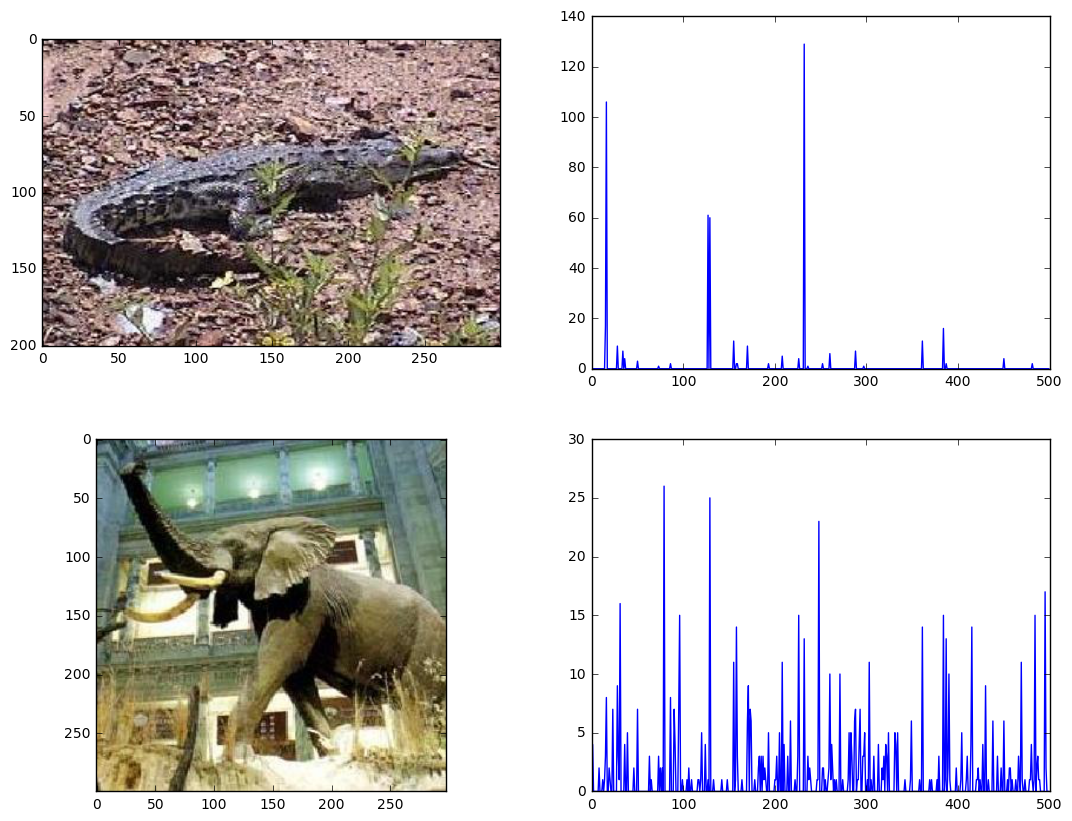

In [28]:
img = sio.imread(dataset.getImagePath('crocodile',15))
image_representation = extract_and_describe(img,kmeans)

plt.figure(figsize=(13,10))
plt.subplot(2,2,1)
plt.imshow(img)

plt.subplot(2,2,2)
plt.plot(image_representation)

img = sio.imread(dataset.getImagePath('elephant',18))
image_representation = extract_and_describe(img,kmeans)

plt.subplot(2,2,3)
plt.imshow(img)

plt.subplot(2,2,4)
plt.plot(image_representation)
plt.show()

In [29]:
classes_idx=range(len(classes)) #genera numeri interi da zero a len(classes)-1

print (classes)
print (classes_idx)

['emu', 'elephant', 'crocodile']
range(0, 3)


In [30]:
def describe_dataset(dataset,kmeans):
    y=list()
    X=list()
    paths=list()
    
    classes = dataset.getClasses()
    total_image= dataset.getLength()
    current_image=0
    start_time=time()
    for class_name in classes:
        for path in dataset.getImagePath(class_name,"all"):
            img=sio.imread(path,as_grey=True)
            feature = extract_and_describe(img,kmeans)
            X.append(feature)
            y.append(classes.index(class_name))
            paths.append(path)
            current_image+=1
            #print("Processing: {:<3} of {:<3}".format(current_image,total_image))
    X=np.array(X)
    y=np.array(y)
    end_time=time()
    print("Elapsed time: {0:0.2f}".format(end_time-start_time))
    return X,y,paths
    

In [31]:
X_training,y_training,paths_training=describe_dataset(training_set,kmeans)
X_test,y_test,paths_test=describe_dataset(test_set,kmeans)

Elapsed time: 26.58
Elapsed time: 11.68


# 5.3

In [32]:
def display_image_and_representation(X,y,paths,classes,idx):
    info = paths[idx].split('/')
    title="Class: {} - Picture: {}".format(info[1],info[2])
    plt.figure(figsize=(12,6))
    plt.figtext(x=0.5,y=1,s=title,horizontalalignment='center',fontsize=14)
    plt.subplot(1,2,1)
    im = sio.imread(paths[idx])
    plt.imshow(im)
    plt.subplot(1,2,2)
    plt.plot(X[idx])
    plt.show()

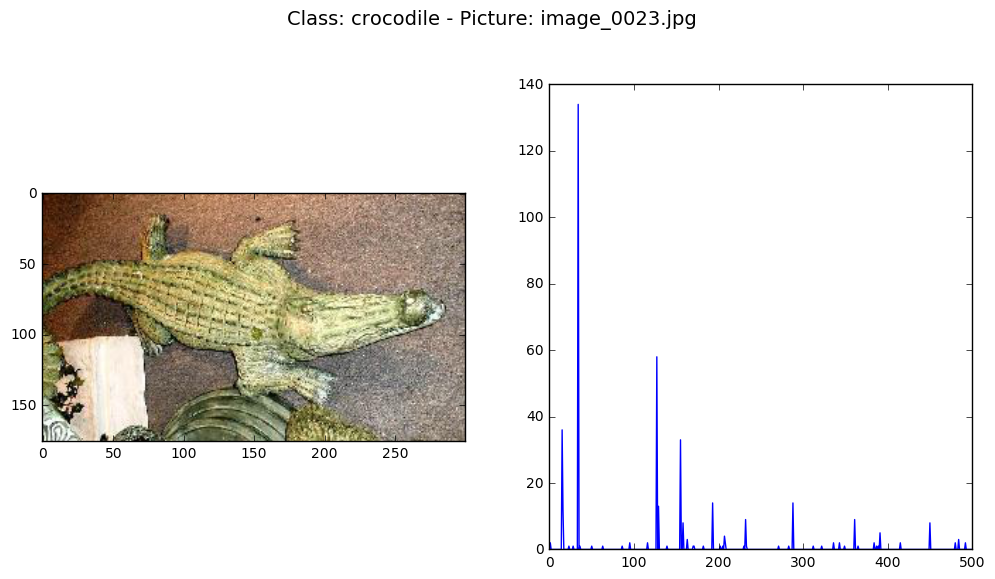

In [33]:
display_image_and_representation(X_training,y_training,paths_training,classes,0)

In [34]:
normalized_bovw_representation = bovw_representation/float(np.sum(bovw_representation))

In [35]:
from sklearn.preprocessing import Normalizer

norm = Normalizer(norm='l1')

X_training_l1 = norm.transform(X_training)
X_test_l1 = norm.transform(X_test)

# 5.4

In [50]:
def compare_representations(bovw_representation,normalized_bovw_representation):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("Occorrenze")
    plt.plot(bovw_representation)
    plt.subplot(1,2,2)
    plt.title("Normalizzato")
    plt.plot(normalized_bovw_representation)
    plt.show()

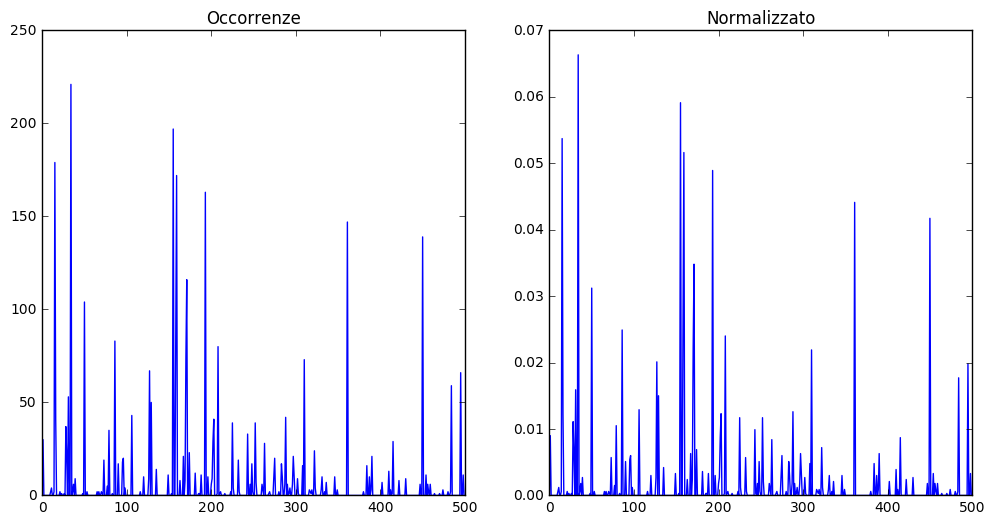

In [51]:
compare_representations(bovw_representation,normalized_bovw_representation)


In [52]:
#binarizziamo il vettore di rappresentazioni X_training
#otterremo una matrice n x 500 in cui l'elemento x_ij
#indica se la parola j-esima era presente nell'immagine i-esima
presence = (X_training>0).astype(int)
#sommiamo tutte le righe (asse "0" della matrice)
#ogni elemento del vettore risultate indicherà il numero di
#righe (=immagini) in cui la parola visuale era presente
df = presence.sum(axis=0)

In [53]:
#otteniamo prima il numero di immagini
n=len(X_training)
#calcoliamo il termine secondo la formula riportata prima
idf = np.log(float(n)/(1+df))

In [54]:
X_training_tfidf=X_training*idf
X_test_tfidf=X_test*idf

In [55]:
norm = Normalizer(norm='l2')

X_training_tfidf_l2 = norm.transform(X_training_tfidf)
X_test_tfidf_l2 = norm.transform(X_test_tfidf)

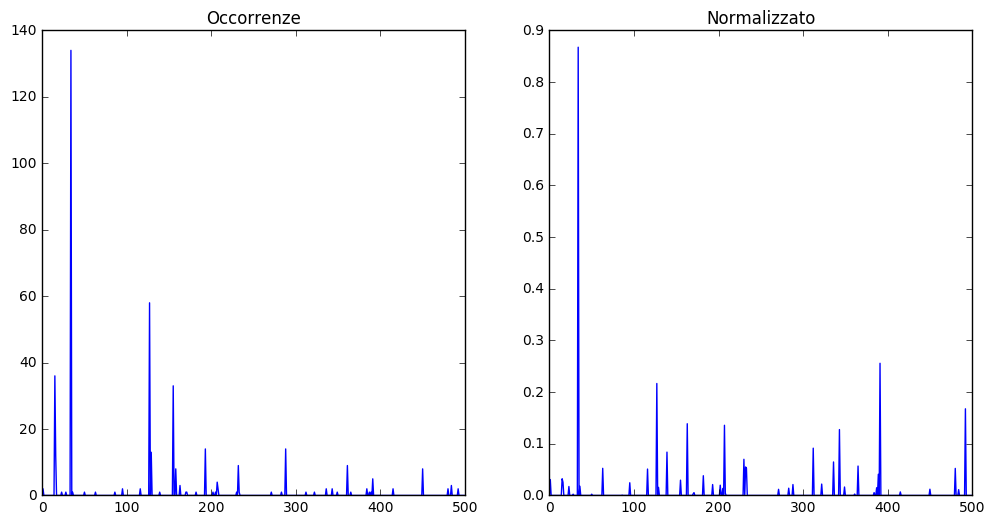

In [56]:
compare_representations(X_training[0],X_training_tfidf_l2[0])

# 5.3

In [57]:
#Cosa cambia tra le due rappresentazioni? 
#I cambiamenti sono più o meno radicali rispetto al caso della normalizzazione L1?
#
#Le due rappresentazioni differiscono oltre che per la scala per il fatto che nel secondo grafico le parole più comuni
#avranno ottenuto a causa dell'importanza minore un attenuazione maggiore, cose che in L1 non accadeva

In [58]:
from sklearn.neighbors import KDTree

tree = KDTree(X_training_tfidf_l2)
#L'oggetto KDTree appea creato ha "memorizzato" e "indicizzato" opportunamente il training set 
#per effettuare delle "query" in maniera efficiente

In [60]:
query_feature = X_test_tfidf_l2[0]
distance, index = tree.query(query_feature)
print (distance[0,0])
print (index[0,0])
#index contiene l'indice del vettore di rappresentazione più vicino all'interno del training set
#distance contiene la distanza tra le due rappresentazioni

1.11765242127
32


In [61]:
closest_sample = X_training_tfidf_l2[index[0][0]]
distance2 = np.sqrt(((closest_sample-query_feature)**2).sum())
print (distance[0,0])
print (distance2)

1.11765242127
1.11765242127


In [80]:
def query_image(tree,paths_training,paths_test,X_test_tfidf_l2,idx):
    query_representation = X_test_tfidf_l2[idx]
    _, closest_idx = tree.query(query_representation)
    
    query_im = sio.imread(paths_test[idx])
    closest_im = sio.imread(paths_training[closest_idx[0,0]])
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(query_im)
    info = paths_test[idx].split('/')
    plt.title("Query Image - Class: "+info[1])
    
    plt.subplot(1,2,2)
    plt.imshow(closest_im)
    info = paths_training[closest_idx[0,0]].split('/')
    plt.title("Closest Image - Class: "+info[1])
    
    plt.show()

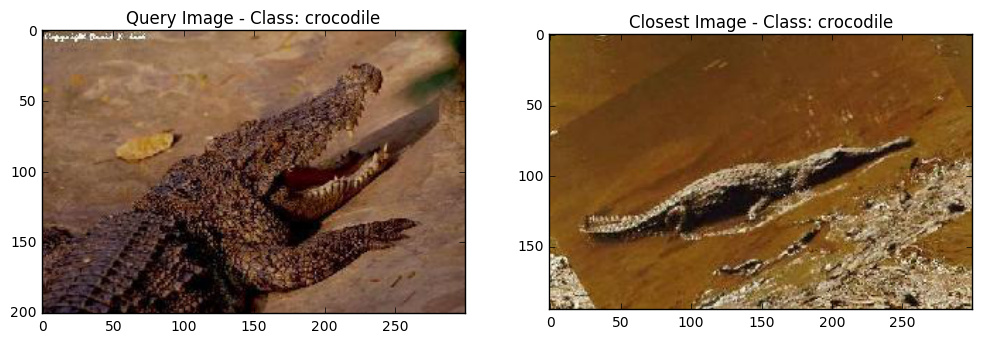

In [95]:
random_idx = np.random.randint(len(X_test_tfidf_l2))
query_image(tree,paths_training,paths_test,X_test_tfidf_l2,random_idx)

# 6.2

In [112]:
def three_closest(tree,paths_training,paths_test,X_test_tfidf_l2,idx):
    query_representation = X_test_tfidf_l2[idx]
    _, closest_idx = tree.query(query_representation,k=3)
    query_im = sio.imread(paths_test[idx])
    closest_im1 = sio.imread(paths_training[closest_idx[0,0]])
    closest_im2 = sio.imread(paths_training[closest_idx[0,1]])
    closest_im3 = sio.imread(paths_training[closest_idx[0,2]])
    
    plt.figure(figsize=(12,8))
    plt.subplot(2,2,1)
    plt.imshow(query_im)
    info = paths_test[idx].split('/')
    plt.title("Query Image - Class: "+info[1])
    
    plt.subplot(2,2,2)
    plt.imshow(closest_im1)
    info = paths_training[closest_idx[0,0]].split('/')
    plt.title("Closest Image1 - Class: "+info[1])
    
    plt.subplot(2,2,3)
    plt.imshow(closest_im2)
    info = paths_training[closest_idx[0,1]].split('/')
    plt.title("Closest Image2 - Class: "+info[1])
    plt.subplot(2,2,4)
    plt.imshow(closest_im3)
    info = paths_training[closest_idx[0,2]].split('/')
    plt.title("Closest Image3 - Class: "+info[1])
    
    plt.show()

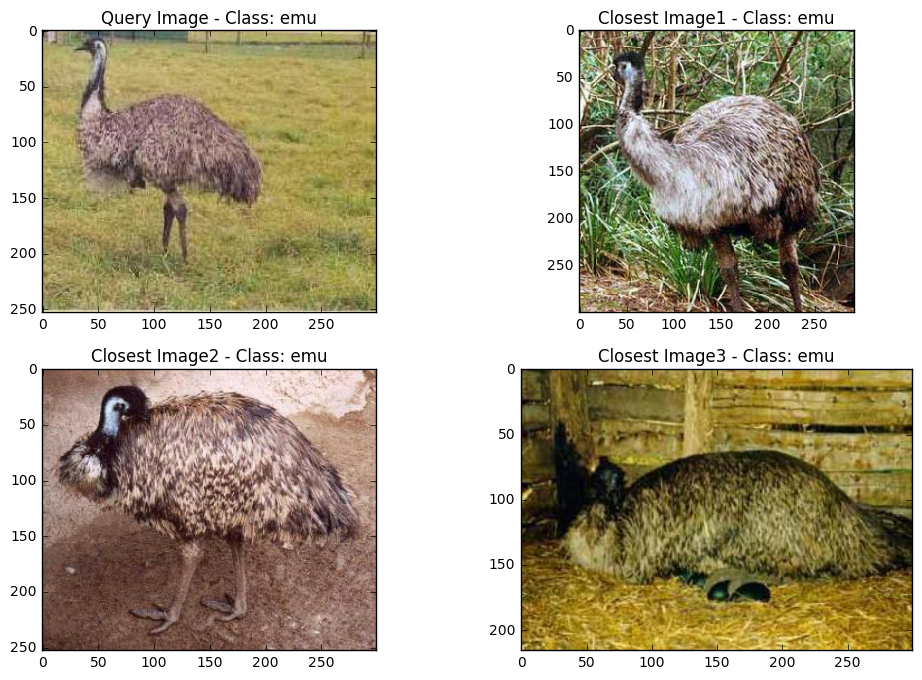

In [114]:
random_idx = np.random.randint(len(X_test_tfidf_l2))
three_closest(tree,paths_training,paths_test,X_test_tfidf_l2,random_idx)

In [124]:
import _pickle as cPickle

#la keyword with permette di creare contesti in python
#i contesti sono delle porzioni di codice nelle quali viene
#resa disponibile una determinata risorsa, nel nostro caso
#il file pkl su cui scrivere i dati
with open("caltech101_bovw.pkl",'wb') as out:
    cPickle.dump({ #per scrivere più dati, li inseriamo dentro un dizionario
            'X_training':X_training,
            'X_training_l1':X_training_l1,
            'X_training_tfidf_l2':X_training_tfidf_l2,
            'y_training':y_training,
            'paths_training':paths_training,
            'X_test':X_test,
            'X_test_l1':X_test_l1,
            'X_test_tfidf_l2':X_test_tfidf_l2,
            'y_test':y_test,
            'paths_test':paths_test,
            'classes':classes,
            'kmeans':kmeans
        },out)

def load_dump():
    with open("caltech101_bovw.pkl") as inp:
        return cPickle.load(inp)